# Manually choosing parameters, SARIMA(p,d,q)(P,D,Q)m

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sarimax import pre_process
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pmd
from sarimax import find_parameters
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

                      Total
Datetime                   
2023-07-15 17:00:00  1725.0
2023-07-15 18:00:00  1756.0
2023-07-15 19:00:00  1756.0
2023-07-15 20:00:00  1767.0
2023-07-15 21:00:00  1778.0


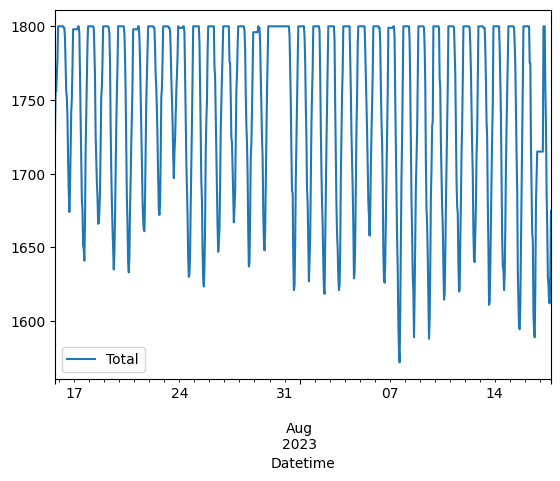

In [69]:
df = pre_process(csv_data_file_path='./Data/Bill_Bryson_Data.csv', resample_period='H')
df = df[['Total']]
print(df.head())
df.plot()
plt.show()

In [76]:
# H0, data is not stationary
# H1, data is stationary
print(adfuller(df['Total'])[1])

# Hence we have enough evidence to reject the null hypothesis
# Also, we won't have to do any differencing/log-transformation/ box-cox transformations as our data is already stationary
ndiff = pmd.arima.ndiffs(df['Total'], test='adf')
print(f"Number of differencing recommended {ndiff} by pmdarima")

0.12081584975430543
0.01986629361530417
Number of differencing recommended 0 by pmdarima


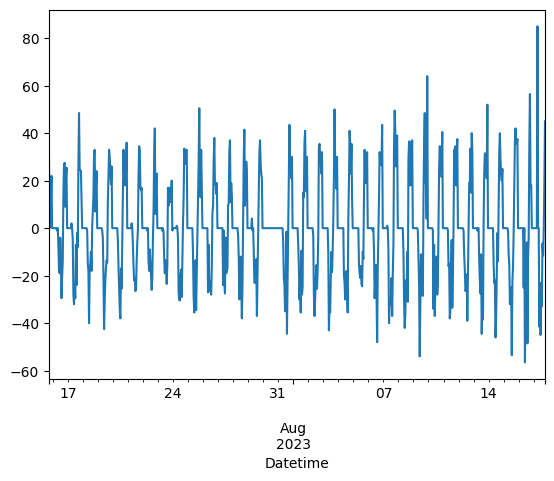

1.3233264520768448e-26


In [71]:
df_diff = df.diff().iloc[1:] # could also just do dropna() but want to be sure exactly what's happening
df_diff['Total'].plot()
plt.show()
print(adfuller(df_diff['Total'])[1])# Makes a statistically significant different!

In [72]:
# Could also use pmdarima package to automatically find differencing...
ndiff = pmd.arima.ndiffs(df['Total'], test='adf')
print(f"Number of differencing recommended {ndiff}")
# pmd.arima.nsdiff() to get seasonality differencing

Number of differencing recommended 0


0
9.213806852980883e-15


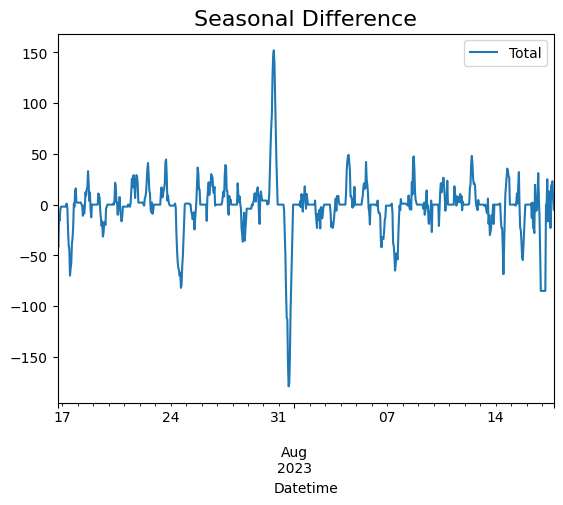

<Figure size 3000x600 with 0 Axes>

In [73]:
print(pmd.arima.ndiffs(df))

df_diff_season = df.diff(24)
df_diff_season = df_diff_season.dropna()
df_diff_season.plot()
plt.title("Seasonal Difference", fontsize=16)
plt.figure(figsize=(30, 6))

print(adfuller(df_diff_season)[1])
# From ADT test we can determine that a differencing with a lag of m=24 will make our data stationary. So we have D = 1

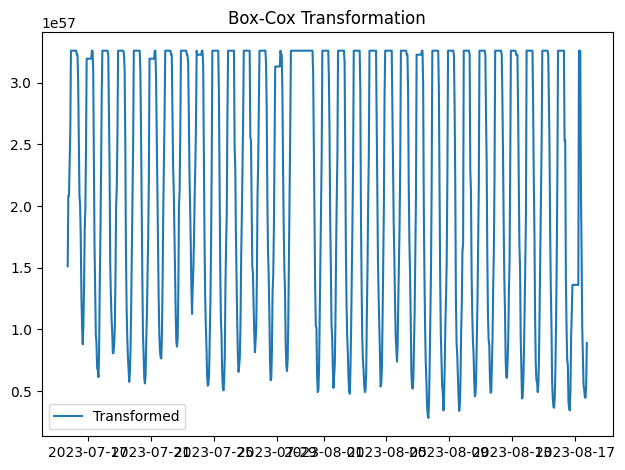

(-2.4784112435594094, 0.12081584975430543, 20, 773, {'1%': -3.438837902109151, '5%': -2.8652862410999114, '10%': -2.568764869203001}, 5752.131735988944)
(-1.0228319174865255, 0.7448460710715993, 20, 773, {'1%': -3.438837902109151, '5%': -2.8652862410999114, '10%': -2.568764869203001}, 202355.45978769878)


In [74]:
transformed_values, lambda_value = boxcox(df['Total'])
original_values = inv_boxcox(transformed_values, lambda_value)

# Plot original and transformed values
#plt.figure(figsize=(10, 6))
plt.plot(df.index, transformed_values, label='Transformed')
plt.title('Box-Cox Transformation')
plt.legend()
plt.tight_layout()
plt.show()
print(adfuller(df['Total']))
print(adfuller(transformed_values))
# Box-cox transformation makes




With observation and exploration (seasonal_decomposition, acf and pacf plots), I believe I should difference both d=1 and D=1. However, the pmdarima functions ndiffs() and nsdiff() suggest I shouldn't. I will continue doing so, but check back once I have more data.

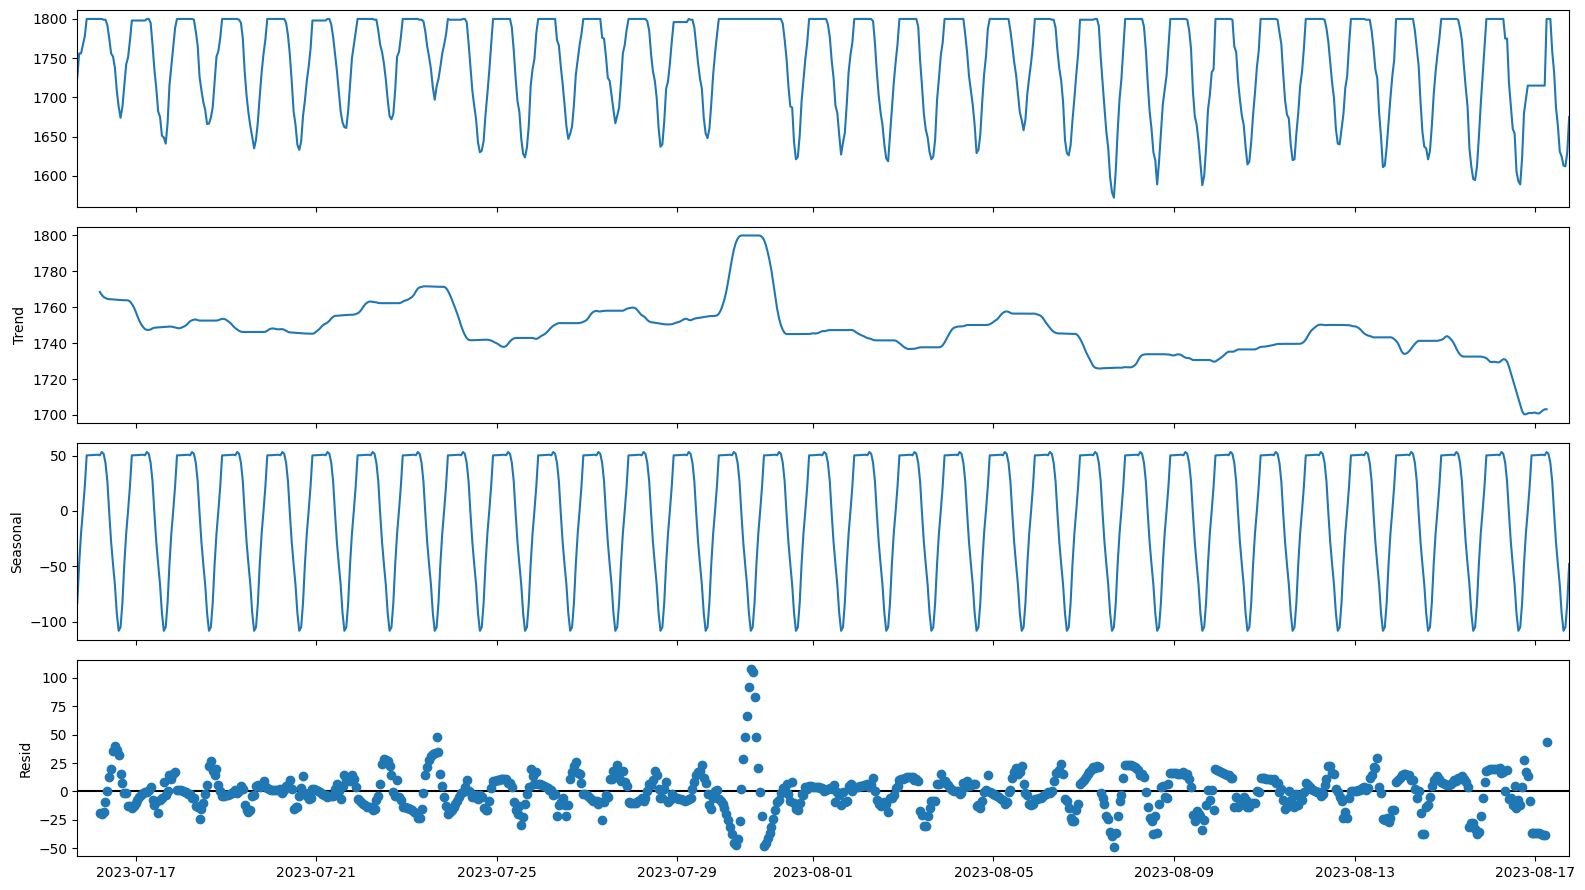

In [75]:
fig = seasonal_decompose(df).plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()


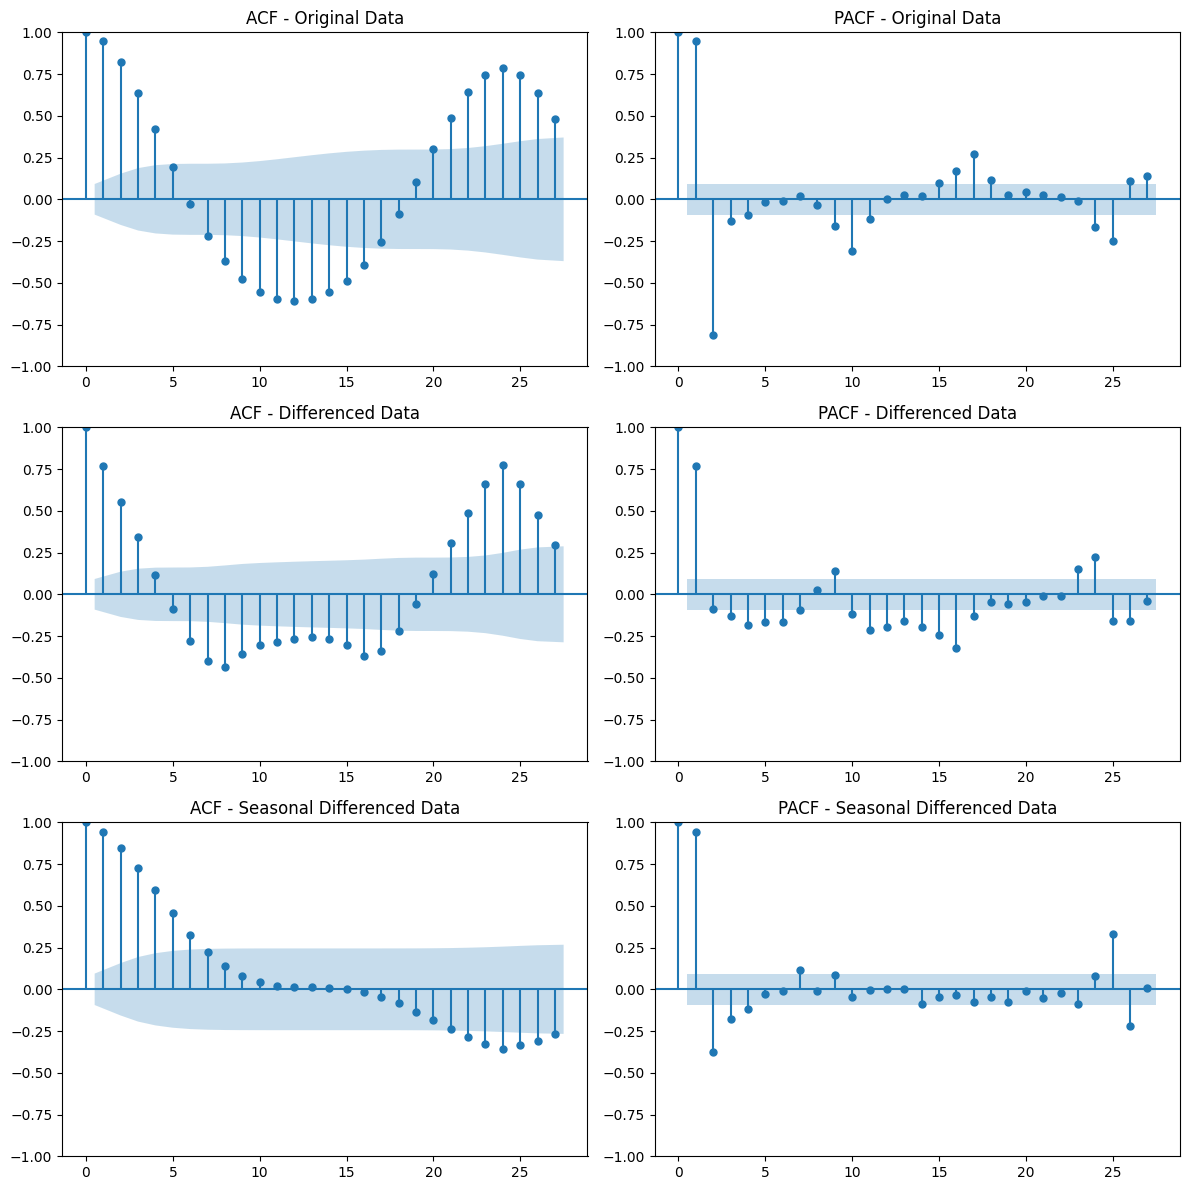

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

plot_acf(df, ax=axes[0, 0], title='ACF - Original Data')
plot_pacf(df, ax=axes[0, 1], title='PACF - Original Data')

plot_acf(df_diff, ax=axes[1, 0], title='ACF - Differenced Data')
plot_pacf(df_diff, ax=axes[1, 1], title='PACF - Differenced Data')

plot_acf(df_diff_season, ax=axes[2, 0], title='ACF - Seasonal Differenced Data')
plot_pacf(df_diff_season, ax=axes[2, 1], title='PACF - Seasonal Differenced Data')

plt.tight_layout()
plt.show()

In [12]:
find_parameters(df=df, col='Total')
find_parameters(df=df_diff, col='Total')
find_parameters(df=df_diff_season, col='Total')



 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=8.35 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=14.30 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=16.60 sec
 ARIMA(1,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=21.70 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=4193.453, Time=12.30 sec
 ARIMA(2,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=24.07 sec
 ARIMA(1,0,0)(2,0,1)[24]             : AIC=2794.216, Time=19.75 sec

Best model:  ARIMA(1,0,0)(2,0,1)[24] intercept
Total fit time: 182.770 seconds
 ARIMA(1,0,0)(2,0,1)[24] intercept
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3983.543, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2827.715, Time=4.67 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=3361.216, Time=2.48 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3983.543, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=3140.001, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=2972.992, Time